In [3]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir.parent.parent)
sys.path.insert(0, module_dir + '/non-grad3D/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
%matplotlib inline
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim
from mpl_toolkits.axes_grid1 import make_axes_locatable
DTYPE = 'float32'

C:\Users\pinak\Documents\GitHub


In [4]:
# load learned solution
dim = 3
net = arch.LSTMForgetNet(50, 3, tf.float32, name="Thomas")
net.load_weights('../../../non-grad3D/data/Thomas/400k/{}'.format(net.name)).expect_partial()
X = tf.random.uniform(shape=(10, dim))
net(*tf.split(X, dim, axis=-1))

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.6865418 ],
       [0.6710579 ],
       [0.6817834 ],
       [0.6848355 ],
       [0.6679096 ],
       [0.69596535],
       [0.636397  ],
       [0.7041631 ],
       [0.69236   ],
       [0.70098805]], dtype=float32)>

In [5]:
# compute Monte-Carlo estimate
dim = 3
n_particles = int(5e6)
n_subdivisions = 50
n_int_subdivs = 1000
save_folder = '../../../non-grad3D/data/Thomas'
n_steps = 1000
n_repeats = 100
dt = 0.01
alpha, beta, rho = 10., 8./3., 28.
sigma = 10.
D = sigma**2 / 2.
t = dt * n_steps
r = 1.0
sigma = np.sqrt(2.)
s = 1.

def mu_np(X, b=0.2):
    x, y, z = np.split(X, 3, axis=-1)
    p = np.sin(s*y) - b*x 
    q = np.sin(s*z) - b*y 
    r = np.sin(s*x) - b*z
    return np.concatenate([p, q, r], axis=-1)

X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones(dim)).sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivisions, mu_np, sigma, X0, tick_size=20, title_size=20, cbar_tick_size=15)
mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)
#mc_prob.compute_all(n_steps=n_steps, dt=dt)

Time taken by propagate is 529.868275642395 seconds
Time taken by set_grid is 14.036036252975464 seconds
Time taken by assign_pts is 16.80639672279358 seconds
Time taken by ready is 560.7107086181641 seconds


In [16]:
# set up plotting parameters
scale = 0
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale

In [10]:
# projecter for 3D to 2D
def projector(net, low, high, idx, n_subdivs, n_int_subdivs, dtype='float32'):
  x = np.linspace(low[idx[0]], high[idx[0]], num=n_subdivs+1, endpoint=True).astype(dtype)[1:]
  y = np.linspace(low[idx[1]], high[idx[1]], num=n_subdivs+1, endpoint=True).astype(dtype)[1:]
  z = np.linspace(low[idx[2]], high[idx[2]], num=n_int_subdivs+1, endpoint=True).astype(dtype).reshape(-1, 1)
  delta = (high[idx[0]] - low[idx[0]]) * (high[idx[1]] - low[idx[1]]) / (n_subdivs)**2
  delta_z = (high[idx[2]] - low[idx[2]]) / n_int_subdivs
  weights = np.ones_like(z) 
#   for iw, w in enumerate(weights):
#     if iw % 2 == 0 and iw > 0:
#       weights[iw][0] = 2. 
#     else:
#       weights[iw][0] = 4.
  weights *= (delta_z)
  weights[0] *= .5
  weights[-1] *= .5
  prob = np.zeros((n_subdivs, n_subdivs))
  one = tf.ones_like(z)
  for i in range(n_subdivs):
      for j in range(n_subdivs):
        args = [e for _, e in sorted(zip(idx, [x[i]*one, y[j]*one, z]))]
        prob[i, j] = (tf.exp(net(*args)).numpy().reshape((-1,)) * weights).sum()
  prob /= (prob.sum()*delta)
  return prob

Time taken by compute_p2 is 16.22821879386902 seconds


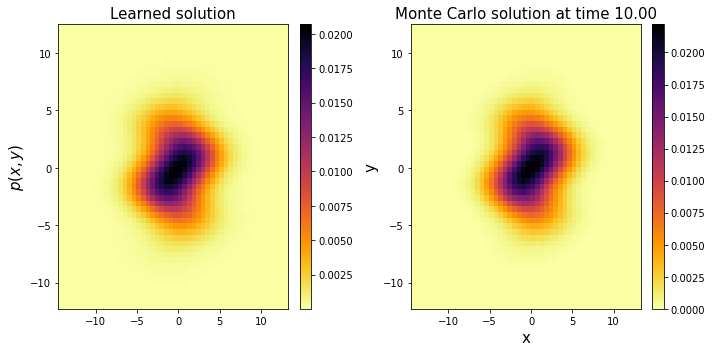

In [22]:
grid = mc_prob.get_grid()
low = grid.mins
high = grid.maxs
n_subdivs = n_subdivisions
n_int_subdivs = 100

x_ = np.linspace(low[0], high[0], num=n_subdivs, endpoint=True).astype('float32')
y_ = np.linspace(low[1], high[1], num=n_subdivs, endpoint=True).astype('float32')
z_ = np.linspace(low[2], high[2], num=n_subdivs, endpoint=True).astype('float32')

    
fig_all = plt.figure(figsize=(10, 5))
ax_1l = fig_all.add_subplot(121) 
ax_1m = fig_all.add_subplot(122)


# ax_2l = fig_all.add_subplot(323) 
# ax_2m = fig_all.add_subplot(324)

# ax_3l = fig_all.add_subplot(325) 
# ax_3m = fig_all.add_subplot(326)


div_1 = make_axes_locatable(ax_1l)
cax_1 = div_1.append_axes('right', '5%', '5%')
# div_2 = make_axes_locatable(ax_2l)
# cax_2 = div_2.append_axes('right', '5%', '5%')
# div_3 = make_axes_locatable(ax_3l)
# cax_3 = div_3.append_axes('right', '5%', '5%')

div_4 = make_axes_locatable(ax_1m)
cax_4 = div_4.append_axes('right', '5%', '5%')
# div_5 = make_axes_locatable(ax_2m)
# cax_5 = div_5.append_axes('right', '5%', '5%')
# div_6 = make_axes_locatable(ax_3m)
# cax_6 = div_6.append_axes('right', '5%', '5%')


z_m = mc_prob.compute_p2(0, 1, save=False)
z_m  /= (z_m.sum() * grid.h[0] * grid.h[1])
# y, x = np.meshgrid(y_, x_)
im = ax_1m.pcolormesh(x_, y_, z_m.T, cmap='inferno_r', shading='auto')
cbar = fig_all.colorbar(im, cax=cax_4, ax=ax_1m)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1m.set_aspect("auto")

# im = ax_2m.pcolormesh(y_, z_, mc_prob.compute_p2(1, 2, save=False).T, cmap='inferno_r', shading='auto')
# cbar = fig_all.colorbar(im, cax=cax_5, ax=ax_2m)
# cbar.ax.tick_params(labelsize=cbar_tick_size)
# #cbar.formatter.set_powerlimits((0, 0))
# ax_2m.set_aspect("auto")

# im = ax_3m.pcolormesh(z_, x_, mc_prob.compute_p2(2, 0, save=False).T, cmap='inferno_r', shading='auto')
# cbar = fig_all.colorbar(im, cax=cax_6, ax=ax_3m)
# cbar.ax.tick_params(labelsize=cbar_tick_size)
# #cbar.formatter.set_powerlimits((0, 0))
# ax_3m.set_aspect("auto")

ax_1m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_2m.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='major', labelsize=tick_size)
ax_3m.tick_params(axis='both', which='minor', labelsize=tick_size)

ax_1m.set_title('Monte Carlo solution at time {:.2f}'.format(t), fontsize=title_size)
ax_1m.set_xlabel('x', fontsize=xlabel_size)
ax_1m.set_ylabel('y', fontsize=ylabel_size)
ax_2m.set_xlabel('y', fontsize=xlabel_size)
ax_2m.set_ylabel('z', fontsize=ylabel_size)
ax_3m.set_xlabel('z', fontsize=xlabel_size)
ax_3m.set_ylabel('x', fontsize=ylabel_size)




ax_1l.clear()
cax_1.cla()
z_1l = projector(net, low, high, [0, 1, 2], n_subdivs, n_int_subdivs)
im = ax_1l.pcolormesh(x_, y_, z_1l.T, cmap='inferno_r', shading='auto')
ax_1l.set_title('Learned solution', fontsize=title_size)
ax_1l.tick_params(axis='both', which='major', labelsize=tick_size)
ax_1l.tick_params(axis='both', which='minor', labelsize=tick_size)
cbar = fig_all.colorbar(im, cax=cax_1, ax=ax_1l)
cbar.ax.tick_params(labelsize=cbar_tick_size)
#cbar.formatter.set_powerlimits((0, 0))
ax_1l.set_aspect("auto")


# z_2l = fk.make_plot(n_steps, dt, n_repeats, 1, 2, 0)

# ax_2l.clear()
# cax_2.cla() 
# z_2l = projector(net, low, high, [1, 2, 0], n_subdivs, n_int_subdivs)
# im = ax_2l.pcolormesh(y_, z_, z_2l.T, cmap='inferno_r')
# ax_2l.tick_params(axis='both', which='major', labelsize=tick_size)
# ax_2l.tick_params(axis='both', which='minor', labelsize=tick_size)
# cbar = fig_all.colorbar(im, cax=cax_2, ax=ax_2l)
# cbar.ax.tick_params(labelsize=cbar_tick_size)
# #cbar.formatter.set_powerlimits((0, 0))
# ax_2l.set_aspect("auto")

# # z_3l = fk.make_plot(n_steps, dt, n_repeats, 2, 0, 1)

# ax_3l.clear()
# cax_3.cla()
# z_3l = projector(net, low, high, [2, 0, 1], n_subdivs, n_int_subdivs)
# im = ax_3l.pcolormesh(z_, x_, z_3l.T, cmap='inferno_r')
# ax_3l.tick_params(axis='both', which='major', labelsize=tick_size)
# ax_3l.tick_params(axis='both', which='minor', labelsize=tick_size)
# cbar = fig_all.colorbar(im, cax=cax_3, ax=ax_3l)
# cbar.ax.tick_params(labelsize=cbar_tick_size)
# # cbar.formatter.set_powerlimits((0, 0))
# ax_3l.set_aspect("auto")
fig_all.subplots_adjust(wspace=0.5, hspace=0.4)

ax_1l.set_ylabel(r'$p(x, y)$', fontsize=ylabel_size)
# ax_2l.set_ylabel(r'$p(y, z)$', fontsize=ylabel_size)
# ax_3l.set_ylabel(r'$p(z, x)$', fontsize=ylabel_size)
plt.tight_layout()
plt.savefig('../../plots/Thomas.png')